In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSimHebb
from SpikingNetworkModels import EIFNetworkSim

#from DefaultParams import *

import numpy as np

# Time duration and step size of sim in ms
T=12000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)
Tburn=1000
Nburn=int(Tburn/dt)

# Number of E and I neurons in network
Ne = 4000
Ni = 1000
Ns=[Ne,Ni]
N = Ne+Ni


# Connection probabilities and weights between
# E and I neurons
P = np.array([[.1,.1],[.1,.1]])
Jm = 0.5*np.array([[25.0,-150.0],[112.5,-250.0]])/np.sqrt(N)

# Synaptic time constants in ms
tau=np.array([8.0,4.0])


# Neuron parameters
NeuronParams = dict()
NeuronParams['Cm']=1.0
NeuronParams['gL']=1/15.0
NeuronParams['EL']=-72.0
NeuronParams['Vth']=0.0
NeuronParams['Vre']=-75.0
NeuronParams['Vlb']=-100.0
NeuronParams['DeltaT']=1.0
NeuronParams['VT']=-55.0


# Mean-field variables
Q=np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)
Xmf = 0.6*np.array([.04,.02])

# Baseline external input to each neuron
X0 = Xmf*np.sqrt(N)

# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf

# Stimulus params
StimDim = 10
taustim = 25.0
sigmastim = X0.mean()/3.0

print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Params for multi-trial sims
numtrials=2
dtRate=250


tauHebb=20.0
etaHebb=Jm[0,0]/50.0

alpha=1.0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
rBal =  9.882352941176466 22.588235294117638 Hz


In [2]:

import warnings

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
reRand = np.zeros((numtrials,Ne,len(RateTime)))
riRand = np.zeros((numtrials,Ni,len(RateTime)))
reLikeLike = np.zeros((numtrials,Ne,len(RateTime)))
riLikeLike = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for iii in range(numtrials):

        # Get connectivity matrix
        J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

        # External input on top of baseline
        X=np.zeros((StimDim,Nt))
        for j in range(StimDim):
          X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)

        #Jx=np.zeros(N,StimDim)
        Jx=sigmastim*(0.3*np.random.randn(N,StimDim)+.3)
        Jx[Ne:,:]=0

        # Run random connectivity sim
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reRand[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        riRand[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print(iii+1,'of',numtrials,'rSimRand =',1000*reRand[iii,:,:].mean(),1000*riRand[iii,:,:].mean(),'Hz. ',tm()-t0,'s')


        # Compute input correlations, and re-wire network.
        p0=0.1
        Xcoarse = X.copy().reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
        IEXcoarse=Jx[:Ne,:]@Xcoarse
        IEXcoarse = IEXcoarse[:,int(Tburn/dtRate):-int(Tburn/dtRate)]

        XXCorrMatrix = np.corrcoef(IEXcoarse)        
        Pe1=XXCorrMatrix.copy()
        print('corr')

        # XXCovMatrix = np.cov(IEXcoarse)        
        # Pe1=XXCovMatrix.copy()
        # print('cov')
        
        # JexJexMatrix = Jx[:Ne,:]@Jx[:Ne,:].T
        # Pe1=JexJexMatrix.copy()
        # print('JxJx')
        
        Pe1=Pe1-Pe1.min()
        Pe1=Pe1-Pe1*np.eye(Ne)
        Pe1 = Pe1*(alpha*p0/Pe1.mean())
        Pe1[Pe1<0]=0
        MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))
        JLikeLike=J.copy()
        JLikeLike[:Ne,:Ne]=MaskEE*JLikeLike[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))
        
        # Run like-like sims.
        se,si,VeRec = EIFNetworkSim(JLikeLike,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reLikeLike[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        riLikeLike[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print(iii+1,'of',numtrials,'rSimLikeLike =',1000*reLikeLike[iii,:,:].mean(),1000*riLikeLike[iii,:,:].mean(),'Hz. ',tm()-t0,'s')

print('Sims complete.')        

1 of 2 rSimRand = 8.938333333333333 16.55708333333334 Hz.  28.51587200164795 s
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
corr
1 of 2 rSimLikeLike = 9.086854166666667 16.801333333333336 Hz.  57.231576919555664 s
2 of 2 rSimRand = 9.102562500000003 16.82625 Hz.  85.1718418598175 s
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
corr
2 of 2 rSimLikeLike = 9.290125000000002 17.143833333333333 Hz.  113.43843293190002 s
Sims complete.


3974 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2
Mean EE corr: 0.037150523740177695
Std EE corr: 0.22486646481562503
Mean connected EE corr: 0.03965107748079326
Mean unconnected EE corr: 0.03687284557893283
3979 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2
Mean EE corr: 0.037250745986092806
Std EE corr: 0.22769649471114545
Mean connected EE corr: 0.05344055002031461
Mean unconnected EE corr: 0.0354499443805889


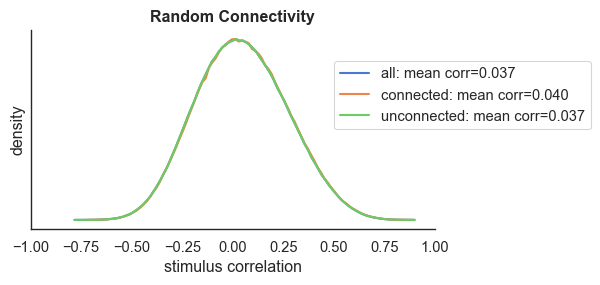

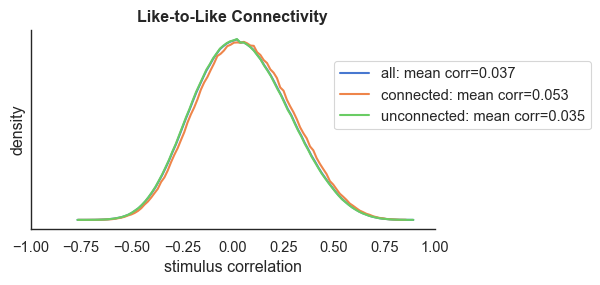

In [3]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'


rmin=1.0/1000

nt=numtrials


# Counts from rates with burn-in
ECounts = dtRate*reRand[:nt,:,int(Tburn/dtRate):-int(Tburn/dtRate)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())


hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()

##################



# Counts from rates with burn-in
ECounts = dtRate*reLikeLike[:nt,:,int(Tburn/dtRate):-int(Tburn/dtRate)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

Jee=JLikeLike[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())


hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()


In [4]:
# import pickle
# filename='./Data/MultiTrialCorrBased.npy'

# objects=(reRand,riRand,reLikeLike,riLikeLike)
# with open(filename, 'wb') as f:
#     pickle.dump(objects, f)

print(alpha)


1.0
